This notebook plots BDT value of darkphoton to electron pair and to muon pair separately.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot

import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.metfilter import MetFilters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import json

dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

dataset=dict(
    sig2mu2e={'files': [], 'treename': 'ffNtuplizer/ffNtuple'},
)

for k in dataset2mu2e_: dataset['sig2mu2e']['files'].extend(dataset2mu2e_[k])

In [10]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal datasets')
        type_axis    = hist.Cat('typed', 'matched decay product')
        mva_axis     = hist.Bin('mva', 'BDT value', 50, -10, 10)
    
        self._accumulator = processor.dict_accumulator({
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis, type_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'].content,
            py=df['pfjet_p4.fCoordinates.fY'].content,
            pz=df['pfjet_p4.fCoordinates.fZ'].content,
            energy=df['pfjet_p4.fCoordinates.fT'].content,
            mva=df['pfjet_mva'].content,
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
        )
        darkphotons = genparticles[genparticles.pid==32]
        dp_el = darkphotons[df['gen2_pid']==11]
        dp_mu = darkphotons[df['gen2_pid']==13]
        matchmask_el = leptonjets.match(dp_el, deltaRCut=0.3)
        matchmask_mu = leptonjets.match(dp_mu, deltaRCut=0.3)
        
        metfiltermask = np.logical_or.reduce([df[mf] for mf in MetFilters])
        
        leptonjets_el = leptonjets[matchmask_el][metfiltermask]
        leptonjets_mu = leptonjets[matchmask_mu][metfiltermask]
        
        output['mva'].fill(dataset=dataset, typed='electron type', mva=leptonjets_el.mva.flatten())
        output['mva'].fill(dataset=dataset, typed='muon type', mva=leptonjets_mu.mva.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [11]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12,),
                                  chunksize=500000,
                                 )

Processing:   0%|          | 0/150 [00:00<?, ?items/s]/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7

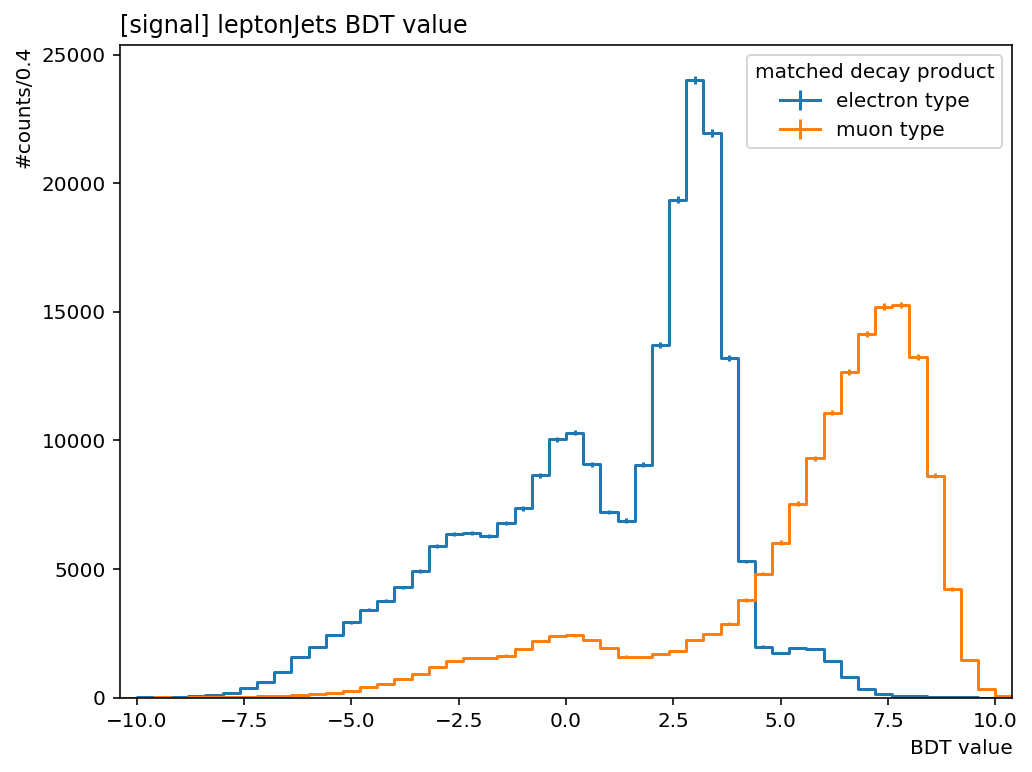

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot1d(output['mva'].project('dataset'), overlay='typed', ax=ax, overflow='all')

ax.set_title('[signal] leptonJets BDT value', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");